In [1]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
net = ContTempNetwork.load('fig3_network')
net_heat = ContTempNetwork.load('fig3_network_heat')

In [3]:
lamdas2=list(np.logspace(-4,2,200))
lamdas1=list(np.logspace(-7,-4,100, endpoint=False))
lamdas = lamdas1 + lamdas2
between_lamdas=np.linspace(-7,2,300)

# Clustering

In [5]:
list_forw_flows = []

for i, l in enumerate(lamdas):
    with open(f'//scratch/tmp/180/skoove/experiment/T/T{l:.06f}', 'rb') as f:
        T_list = pickle.load(f)['T']
    list_forw_flows.append(FlowIntegralClustering(T_list=T_list,
                                  time_list=net.times,
                                  verbose=False))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


KeyboardInterrupt: 

In [8]:
multi_res1 = {}

for i, lamda in enumerate(lamdas1):
    flowintegralclustering = list_forw_flows[i]
    clustering = SparseClustering(p1=flowintegralclustering.p1, p2=None,
                        T=flowintegralclustering.T_list[-1], S=flowintegralclustering.I_list[0])
    clusters, stabilites, seeds = parallel_clustering.compute_parallel_clustering(clustering, num_repeat=50, nproc=50, 
                                verbose=False, n_meta_iter_max=1000, 
                                n_sub_iter_max=1000, 
                                clust_verbose=False, print_num_loops=False)
    multi_res1[lamda] = clusters
    print(i)

file=f'//scratch/tmp/180/skoove/experiment/clusters1'
with open(file, 'wb') as fopen:
    pickle.dump(multi_res1, fopen)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [14]:
with open('//scratch/tmp/180/skoove/experiment/clusters', 'rb') as f:
    multi_res2 = pickle.load(f)

with open('//scratch/tmp/180/skoove/experiment/clusters1', 'rb') as f:
    multi_res1 = pickle.load(f)

multi_res = multi_res1 | multi_res2

In [15]:
avg_csize_forw = [np.mean([len(c) for c in \
                   multi_res[lamda] if len(c)>1]) for lamda in lamdas]

NVI_forw = [avg_norm_var_information(multi_res[lamda]) for lamda in lamdas]

## Heat version

In [16]:
#Clustering of heat version

list_forw_flows_heat = []

for i, l in enumerate(lamdas1):
    with open(f'//scratch/tmp/180/skoove/experiment_heat/T/T{l:.06f}', 'rb') as f:
        T_list = pickle.load(f)['T']

    list_forw_flows_heat.append(FlowIntegralClustering(T_list=T_list,
                                  time_list=net_heat.times,
                                  verbose=False))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [17]:
multi_res_heat_1 = {}

for i, lamda in enumerate(lamdas1):
    flowintegralclustering = list_forw_flows_heat[i]
    clustering = SparseClustering(p1=flowintegralclustering.p1, p2=None,
                        T=flowintegralclustering.T_list[-1], S=flowintegralclustering.I_list[0])
    clusters, stabilites, seeds = parallel_clustering.compute_parallel_clustering(clustering, num_repeat=50, nproc=50, 
                                verbose=False, n_meta_iter_max=1000, 
                                n_sub_iter_max=1000, 
                                clust_verbose=False, print_num_loops=False)
    multi_res_heat_1[lamda] = clusters

file=f'//scratch/tmp/180/skoove/experiment_heat/clusters1'
with open(file, 'wb') as fopen:
    pickle.dump(multi_res_heat_1, fopen)

In [18]:
with open('//scratch/tmp/180/skoove/experiment_heat/clusters', 'rb') as f:
    multi_res_heat_2 = pickle.load(f)

with open('//scratch/tmp/180/skoove/experiment_heat/clusters1', 'rb') as f:
    multi_res_heat_1 = pickle.load(f)
    
multi_res_heat = multi_res_heat_1 | multi_res_heat_2

avg_csize_forw_heat = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas]

NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas]

In [19]:
print(avg_csize_forw)
print(avg_csize_forw_heat)

[81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 80.0, 78.0, 75.0, 66.66, 51.7, 41.2, 32.42, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 25.0, 22.96, 21.0, 18.4, 15.9, 11.0, 10.0, 10.0, 9.8, 9.92, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.96, 9.0, 8.9, 8.0, 7.74, 6.98, 6.84, 5.64, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3

# Plots

In [20]:
array_81 = np.where(np.array(avg_csize_forw)>80.9)[0]
start_81 = lamdas[array_81[0]]
end_81 = lamdas[array_81[-1]]

array_27 = np.where(np.logical_and( np.array(avg_csize_forw) < 28, np.array(avg_csize_forw) >26))[0]
start_27 = lamdas[array_27[0]]
end_27 = lamdas[array_27[-1]]

array_9 = np.where(np.logical_and( np.array(avg_csize_forw) <= 9.1, np.array(avg_csize_forw) >8.9))[0]
start_9 = lamdas[array_9[0]]
end_9 = lamdas[array_9[-1]]

array_3 = np.where(np.logical_and( np.array(avg_csize_forw) < 3.1, np.array(avg_csize_forw) >2.9))[0]
start_3 = lamdas[array_3[0]]
end_3 = lamdas[array_3[-1]]

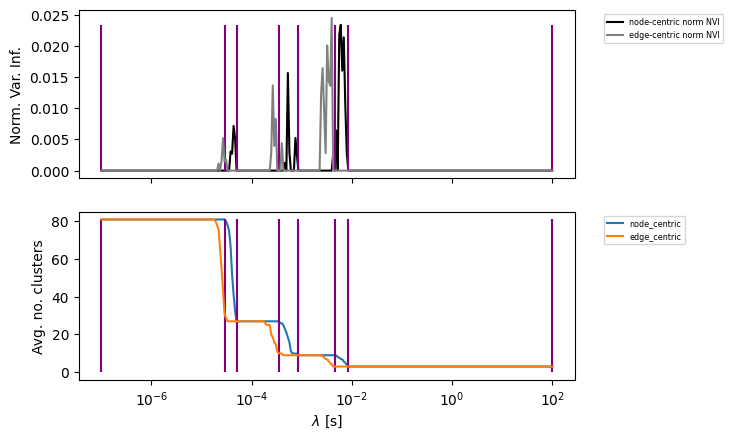

In [22]:
max_NVI = max(NVI_forw)

fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

    
ax1.plot(lamdas, NVI_forw, 'black', label='node-centric norm NVI')
ax1.vlines(x = [start_81, end_81, start_27, end_27, start_9, end_9, start_3, end_3],
           ymin = [0, 0, 0, 0, 0, 0, 0, 0], ymax = [max_NVI, max_NVI, max_NVI, max_NVI, max_NVI, max_NVI, max_NVI, max_NVI], colors='purple')
ax1.plot(lamdas, NVI_forw_heat, 'grey', label='edge-centric norm NVI')

ax2.plot(lamdas, avg_csize_forw, '-', label='node_centric')
ax2.vlines(x = [start_81, end_81, start_27, end_27, start_9, end_9, start_3, end_3],
           ymin = [0, 0, 0, 0, 0, 0, 0, 0], ymax = [81, 81, 81, 81, 81, 81, 81, 81], colors='purple')
ax2.plot(lamdas, avg_csize_forw_heat, '-', label='edge_centric')

ax1.set_xscale('log')

ax2.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Norm. Var. Inf.')
ax2.set_ylabel('Avg. no. clusters')
ax1.legend()
ax1.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))

# Derivatives

In [23]:
def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

In [24]:
vNS = []
for i, lamda in enumerate(lamdas):
    with open(f'//scratch/tmp/180/skoove/experiment_static_weighted_heat/vNS/vNS{lamda:.06f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS.append(S[list(S.keys())[0]][0])

vNS10 = []
for i, lamda in enumerate(lamdas):
    with open(f'//scratch/tmp/180/skoove/experiment_static_weighted_heat/vNS10/vNS{lamda:.06f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS10.append(S[list(S.keys())[0]][0])

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


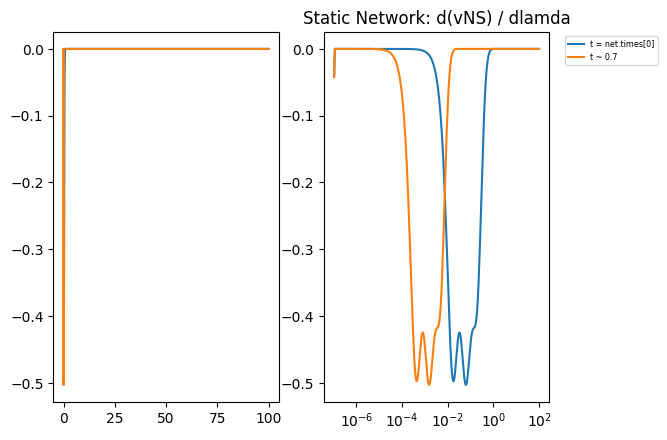

In [25]:
v1 = vNS
w1 = vNS10
v2 = between_lamdas
ds_dt = derivative(v1, v2)
ds10_dt = derivative(w1, v2)

plt.subplot(1, 2, 1)
plt.plot(lamdas[1:], ds_dt)
plt.plot(lamdas[1:], ds10_dt)

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], ds_dt, label='t = net.times[0]')
plt.plot(lamdas[1:], ds10_dt, label='t ~ 0.7')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dvNS_dlamda.eps', format='eps')

plt.show()

## Comparison

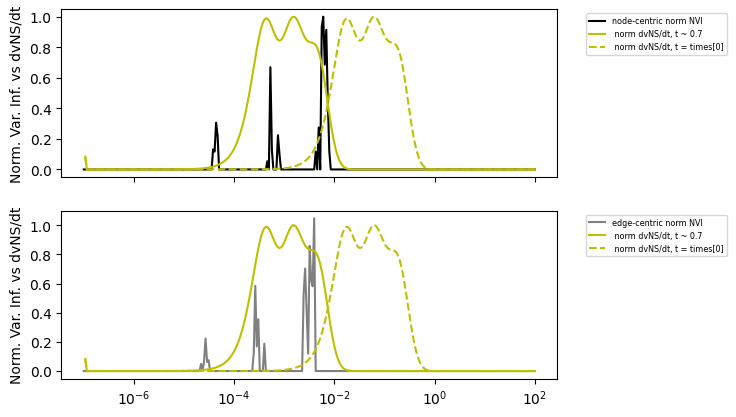

In [26]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

    
ax1.plot(lamdas, NVI_forw / max(NVI_forw), 'black', label='node-centric norm NVI')
ax1.plot(lamdas[1:], ds10_dt / min(ds_dt), 'y', label=' norm dvNS/dt, t ~ 0.7')
ax1.plot(lamdas[1:], ds_dt / min(ds_dt), 'y--', label=' norm dvNS/dt, t = times[0]')
ax1.set_xscale('log')

ax1.set_ylabel('Norm. Var. Inf. vs dvNS/dt')
ax1.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

ax2.plot(lamdas, NVI_forw_heat / max(NVI_forw), 'grey', label='edge-centric norm NVI')
ax2.plot(lamdas[1:], ds10_dt / min(ds_dt), 'y', label=' norm dvNS/dt, t ~ 0.7')
ax2.plot(lamdas[1:], ds_dt / min(ds_dt), 'y--', label=' norm dvNS/dt, t = times[0]')
ax2.set_xscale('log')

ax2.set_ylabel('Norm. Var. Inf. vs dvNS/dt')
ax2.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

# Heat vNS

In [27]:
heat_vNS10 = []
for i, lamda in enumerate(lamdas):
    with open(f'//scratch/tmp/180/skoove/experiment_heat/vNS10/vNS{lamda:.06f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        heat_vNS10.append(S[list(S.keys())[0]][0])

In [28]:
w1 = heat_vNS10
v2 = between_lamdas
heat_ds10_dt = derivative(w1, v2)

# Comparison

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


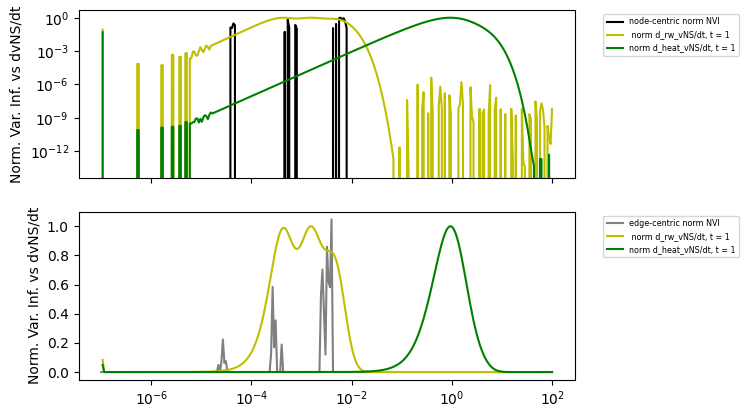

In [36]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

ax1.plot(lamdas, NVI_forw / max(NVI_forw), 'black', label='node-centric norm NVI')
ax1.plot(lamdas[1:], ds10_dt / min(ds10_dt), 'y', label=' norm d_rw_vNS/dt, t = 1')
ax1.plot(lamdas[1:], heat_ds10_dt / min(heat_ds10_dt), 'g', label='norm d_heat_vNS/dt, t = 1')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Norm. Var. Inf. vs dvNS/dt')
ax1.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

ax2.plot(lamdas, NVI_forw_heat / max(NVI_forw), 'grey', label='edge-centric norm NVI')
ax2.plot(lamdas[1:], ds10_dt / min(ds10_dt), 'y', label=' norm d_rw_vNS/dt, t = 1')
ax2.plot(lamdas[1:], heat_ds10_dt / min(heat_ds10_dt), 'g', label='norm d_heat_vNS/dt, t = 1')

ax2.set_xscale('log')
ax2.set_ylabel('Norm. Var. Inf. vs dvNS/dt')
ax2.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

# Temporal vNS

In [30]:
temporal_vNS10 = []
for i, lamda in enumerate(lamdas):
    with open(f'//scratch/tmp/180/skoove/experiment/vNS10/vNS{lamda:.06f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        temporal_vNS10.append(S[list(S.keys())[0]][0])

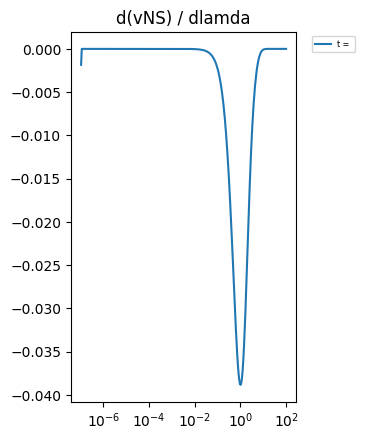

In [31]:
w1 = temporal_vNS10
v2 = between_lamdas
temporal_ds10_dt = derivative(w1, v2)

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], temporal_ds10_dt, label='t = ')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('d(vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dvNS_dlamda.eps', format='eps')

plt.show()

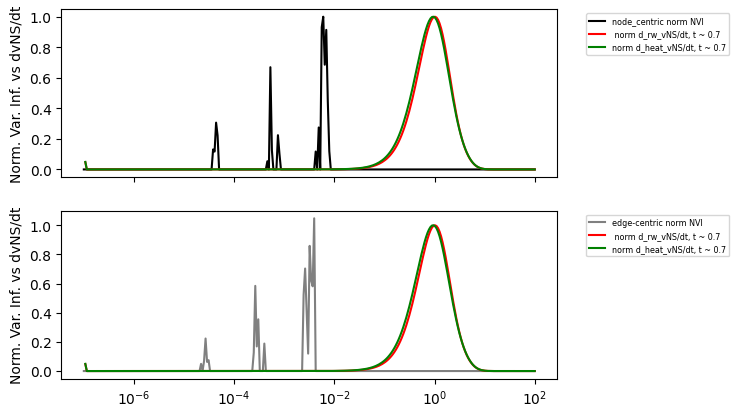

In [32]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

ax1.plot(lamdas, NVI_forw / max(NVI_forw), 'black', label='node_centric norm NVI')
ax1.plot(lamdas[1:], temporal_ds10_dt / min(temporal_ds10_dt), 'r', label=' norm d_rw_vNS/dt, t ~ 0.7')
ax1.plot(lamdas[1:], heat_ds10_dt / min(heat_ds10_dt), 'g', label='norm d_heat_vNS/dt, t ~ 0.7')

ax1.set_xscale('log')
ax1.set_ylabel('Norm. Var. Inf. vs dvNS/dt')
ax1.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

ax2.plot(lamdas, NVI_forw_heat / max(NVI_forw), 'grey', label='edge-centric norm NVI')
ax2.plot(lamdas[1:], temporal_ds10_dt / min(temporal_ds10_dt), 'r', label=' norm d_rw_vNS/dt, t ~ 0.7')
ax2.plot(lamdas[1:], heat_ds10_dt / min(heat_ds10_dt), 'g', label='norm d_heat_vNS/dt, t ~ 0.7')

ax2.set_xscale('log')
ax2.set_ylabel('Norm. Var. Inf. vs dvNS/dt')
ax2.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

In [34]:
net.times

Index([0.12050815137525256, 0.18368605951600975, 0.20846317761405944,
       0.35043962522589595, 0.42877440842917397, 0.47922408479707224,
        0.5129216263938371,  0.5358345311360306,  0.6121989767958406,
        0.6755509429842246,
       ...
         998.6869371727432,   998.7099013339193,   998.7980031749712,
         998.8092041692436,   999.1216098623966,   999.6016233640325,
         999.6334285643916,   999.6578439607773,   999.6709797116994,
         999.7892837739448],
      dtype='float64', name='times', length=10442)